## Setup Env

In this problem, you are going to implement the A* algorithm from scratch to find the shortest path between two locations in California's road network from the United States Census Bureau. 

NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, andfunctions of complex networks.   https://networkx.org/

You need Smopy for this problem. You can install it with 

pip install git+https://github.com/rossant/smopy. 

In order for NetworkX to read Shapefile datasets, you also need GDAL/OGR. You can install it with 

conda install gdal

In [1]:
conda list | grep gdal

gdal                      3.6.2           py311he4f215e_3  
libgdal                   3.6.2                hae2d1d9_3  

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install git+https://github.com/rossant/smopy

  Cloning https://github.com/rossant/smopy to /private/var/folders/03/c5r99rk1475_st2rw57vq__w0000gp/T/pip-req-build-1yykwvi8
  Running command git clone --filter=blob:none --quiet https://github.com/rossant/smopy /private/var/folders/03/c5r99rk1475_st2rw57vq__w0000gp/T/pip-req-build-1yykwvi8
  Resolved https://github.com/rossant/smopy to commit 7818fe30bbcc47c2b14f746b81268e64edd9fc29
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 3.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 14.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 15.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 1

In [4]:
!pip install networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.0 MB/s eta 0:00:00a 0:00:01


In [6]:
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 3.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 16.0 MB/s eta 0:00:0000:0100:01


In [2]:
!python --version

Python 3.11.5


In [3]:
import io
import zipfile
import requests
import networkx as nx
import numpy as np
import pandas as pd
import json
import smopy
import matplotlib.pyplot as plt

## Do Homework

We load the data (a Shapefile dataset) with NetworkX. This dataset contains detailed information about the primary roads in California. NetworkX's read_shp() function returns a graph, where each node is a geographical position, and each edge contains information about the road linking the two nodes.

In [ ]:
url = ('https://github.com/ipython-books/'
       'cookbook-2nd-data/blob/master/'
       'road.zip?raw=true')
r = io.BytesIO(requests.get(url).content)
zipfile.ipFile(r).extractall('data')
g = nx.read_shp('data/tl_2013_06_prisecroads.shp')

In [15]:
'''
https://networkx.org/documentation/stable/release/release_2.6.html
[#4298] Deprecate read_shp, edges_from_line, and write_shp.
'''
!pip install networkx==2.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.8 MB/s eta 0:00:0000:0100:010m
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1


In [2]:
!pip list | grep networkx

networkx              2.5


In [379]:
import networkx as nx

### Download dataset

In [5]:
url = ('https://github.com/ipython-books/'
       'cookbook-2nd-data/blob/master/'
       'road.zip?raw=true')
r = io.BytesIO(requests.get(url).content)
zipfile.ZipFile(r).extractall('data')

### Load dataset

In [6]:
g = nx.read_shp('data/tl_2013_06_prisecroads.shp')

This graph is not necessarily connected, but we need a connected graph in order to compute shortest paths. Here, we take the largest connected subgraph. 

In [7]:
#sgs = list(nx.connected_component_subgraphs(
#    g.to_undirected()))

from networkx import subgraph, connected_components
sgs = list(g.to_undirected().subgraph(c) for c in connected_components(g.to_undirected()))

i = np.argmax([len(sg) for sg in sgs])
sg = sgs[i]
len(sg)

464

We define two positions (with the latitude and longitude) and find the shortest path between these two positions:

In [8]:
pos0 = (37.6026, -121.9926)
pos1 = (34.0569, -118.2427)

Each edge in the graph contains information about the road, including a list of points along this road. We first create a function that returns this array of coordinates, for any edge in the graph:

In [9]:
def get_path(n0, n1):
    """If n0 and n1 are connected nodes in the graph,
    this function returns an array of point
    coordinates along the road linking these two
    nodes."""
    return np.array(json.loads(sg[n0][n1]['Json'])
                    ['coordinates'])

We can notably use the road path to compute its length. We first need to define a function that computes the distance between any two points in geographical coordinates:

In [10]:
# from [https://stackoverflow.com/a/8859667/1595060](https://stackoverflow.com/a/8859667/1595060)
EARTH_R = 6372.8

def geocalc(lat0, lon0, lat1, lon1):
    """Return the distance (in km) between two points
    in geographical coordinates."""
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    dlon = lon0 - lon1
    y = np.sqrt((np.cos(lat1) * np.sin(dlon)) ** 2 +
        (np.cos(lat0) * np.sin(lat1) - np.sin(lat0) *
         np.cos(lat1) * np.cos(dlon)) ** 2)
    x = np.sin(lat0) * np.sin(lat1) + \
        np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
    c = np.arctan2(y, x)
    return EARTH_R * c

Now, we define a function computing a path's length:

In [11]:
def get_path_length(path):
    return np.sum(geocalc(path[1:, 1], path[1:, 0],
                          path[:-1, 1], path[:-1, 0]))


We update our graph by computing the distance between any two connected nodes. We add this information with the distance attribute of the edges:

In [12]:
# Compute the length of the road segments.
for n0, n1 in sg.edges:
    path = get_path(n0, n1)
    distance = get_path_length(path)
    sg.edges[n0, n1]['distance'] = distance

**The last step before we can find the shortest path in the graph is to find the two nodes in the graph that are closest to the two requested positions:**

In [13]:
nodes = np.array(sg.nodes())
# Get the closest nodes in the graph.
pos0_i = np.argmin(
    np.sum((nodes[:, ::-1] - pos0)**2, axis=1))
pos1_i = np.argmin(
    np.sum((nodes[:, ::-1] - pos1)**2, axis=1))

### Exploring NetworkX APIs

In [14]:
pos0_i

357

In [15]:
pos1_i

80

In [16]:
'''
pos0 = (37.6026, -121.9926)
pos1 = (34.0569, -118.2427)
'''
nodes[pos0_i]

array([-121.910796,   36.978296])

In [17]:
nodes[pos1_i]

array([-118.252687,   34.065763])

In [18]:
sg

In [19]:
len(sg)

464

In [20]:
sg.edges

EdgeView([((-121.586642, 39.14501299999999), (-121.59112900000001, 39.14465899999999)), ((-121.586642, 39.14501299999999), (-121.586685, 39.14532899999999)), ((-120.783863, 38.73261699999999), (-121.08555600000001, 38.648096999999986)), ((-118.381962, 34.154371999999995), (-118.155646, 34.149445)), ((-118.381962, 34.154371999999995), (-118.81488, 34.15226599999999)), ((-118.381962, 34.154371999999995), (-118.228437, 34.14744799999999)), ((-118.381962, 34.154371999999995), (-118.375417, 34.15162699999999)), ((-120.448016, 34.811479), (-120.442835, 34.801156999999996)), ((-121.06802100000002, 39.20952599999999), (-121.068171, 39.209544)), ((-121.06802100000002, 39.20952599999999), (-121.035157, 39.236792)), ((-121.543874, 38.84438), (-121.543874, 38.84395099999999)), ((-121.543874, 38.84438), (-121.551105, 38.86174499999999)), ((-121.800303, 38.71878199999999), (-121.800527, 38.71855399999999)), ((-121.800303, 38.71878199999999), (-122.01747300000001, 38.689448999999996)), ((-121.800303,

In [21]:
tuple(nodes[pos0_i])

(-121.910796, 36.978296)

In [22]:
nx.get_edge_attributes(sg,'distance')[((-121.586642, 39.14501299999999),(-121.59112900000001, 39.14465899999999))]

0.3895522448605999

In [23]:
nodes[0]

array([-121.586642,   39.145013])

In [24]:
pos0_i

357

In [25]:
nodes[pos0_i]

array([-121.910796,   36.978296])

In [26]:
friends1 = nx.neighbors(sg, tuple(nodes[pos0_i]))
friends1 = list(friends1)
friends1

[(-121.77227100000002, 36.883852999999995)]

In [27]:
#print(nodes.index([121.77227100000002, 36.883852999999995]))
res = np.where(nodes == list(friends1[0]))
print(np.where(nodes == list(friends1[0])))
print(np.where(nodes == list(friends1[0]))[0][0])

print(nodes[104])

(array([104, 104]), array([0, 1]))
104
[-121.772271   36.883853]


In [28]:
found_neigbors = list(nx.neighbors(sg, tuple(nodes[426])))
for neigbor in found_neigbors:
    print(neigbor)
    print(np.where(nodes == neigbor)[0][0])
    friend = np.where(nodes == neigbor)[0][0]
    try:
        print("distance: ", sg.edges[tuple(nodes[426]), tuple(nodes[friend])]['distance'])
    except:
        continue

(-121.075398, 35.566255)
311
distance:  1.7946783719189463
(-121.069062, 35.549037)
51
(-121.105997, 35.56953599999999)
254
distance:  4.079425534249259


In [29]:
nx.get_edge_attributes(sg,'distance')
'''
104 / 357 has 17 edge
 ((-121.77227100000002, 36.883852999999995),
  (-121.910796, 36.978296)): 17.371936109614413,
'''

'\n104 / 357 has 17 edge\n ((-121.77227100000002, 36.883852999999995),\n  (-121.910796, 36.978296)): 17.371936109614413,\n'

In [30]:
sg.edges[(-121.77227100000002, 36.883852999999995), (-121.910796, 36.978296)]['distance']

17.371936109614413

In [31]:
sg.edges[tuple(nodes[104]), tuple(nodes[357])]['distance']

17.371936109614413

In [47]:
#TEST Update

duplicate_test = [('distance', 'vertex-index')]
duplicate_test.append((10, 1))
duplicate_test.append((10, 2))
print(duplicate_test)

item = [item for item in duplicate_test if item[1] == 2]
print("idx? ", item[0])
list_idx = duplicate_test.index([item for item in duplicate_test if item[1] == 2][0])
duplicate_test[list_idx] = (-100,2)
print(duplicate_test)

[('distance', 'vertex-index'), (10, 1), (10, 2)]
idx?  (10, 2)
[('distance', 'vertex-index'), (10, 1), (-100, 2)]


### TODO: implement A* algorithm from scratch

In [63]:
#TODO implement A* algorithm from scratch
def my_astar_algorithm(graph, source, target, heuristic=None, weights=[1,1]):
    '''
    params {
        graph : NetworkX Graph e.g. here above sg
        source : start node index e.g. pos0_i = 357
        target : destination node index e.g. pos1_i = 80
        heuristic : designated functions e.g. Euclidean Distance or Manhattan Distance
    }
    
    return {
        paths : []
    }    
    I used Index as the "vertex" in Graph because numbers like '(-121.77227100000002, 36.883852999999995)' is too complicated.
    '''
    #we can get nodes from graph
    nodes = np.array(graph.nodes())
    #each list has item (shortest distance(edge) from source, index(vertex))
    opened = []
    closed = []
    
    #check steps
    number_of_steps = 0
    #parents dictionary to save its shortest one, key = index(vertext), value = parent index
    parents = {}
    
    #source's parents is the itself.
    parents[source] = source
    opened.append((0, source));
    
    while True:
        number_of_steps += 1
        if len(opened) == 0:
            print("[LOG]  No Solution Found after" , number_of_steps, "steps!!!")
            break
        
        #sort the shortest distance nodes
        #remove shortest one from opened and add it into closed
        opened.sort()
        selected_node_info = opened.pop(0)
        #getting node's index
        selected_node = selected_node_info[1]
        closed.append(selected_node_info)
        print("[LOG] selected_node: ", selected_node)
        print("[LOG] selected_node_info: ", selected_node_info)
        print("[LOG] opened: ", opened)
        print("[LOG] closed: ", closed)


        #find target node?
        if selected_node == target:
            '''
            calculate path and return total shortest paths.
            '''
            print("[LOG] parents", parents)
            path = [tuple(nodes[target])]
            path_idx = [target]
            while True:
                target = parents.get(target)
                #path.insert(0, p)
                path.insert(0, tuple(nodes[target]))
                path_idx.insert(0,target)
                if target == source:
                    break
            print("[LOG] path_idx ", path_idx)
            return path

        # getting neighbors as position
        found_neigbors_pos = list(graph.neighbors(tuple(nodes[selected_node])))
        # convert index from positions
        found_neigbors_idx = []
        for neigbor_pos in found_neigbors_pos:
            found_neigbors_idx.append(np.where(nodes == neigbor_pos)[0][0])
        print("[LOG] found_neigbors_idx: ", found_neigbors_idx)

        

        #add neigbors nodes into list 'opened'
        if len(found_neigbors_idx) > 0:
            for new_node in found_neigbors_idx:
                print("[LOG] new_node: ",new_node)
                
                #some cases have neighors(line) but doesn't have edge attributes
                try:
                    edge_attr = sg.edges[tuple(nodes[selected_node]), tuple(nodes[new_node])]['distance']
                    print("[LOG] edge_attr: " , edge_attr)
                except:
                    continue
                
                if heuristic is not None:
                    print("[LOG] heuristic: " , heuristic(tuple(nodes[selected_node]), tuple(nodes[new_node])))
                    new_cost = weights[0]*edge_attr + selected_node_info[0] + weights[1]*heuristic(tuple(nodes[selected_node]), tuple(nodes[new_node]))
                else:
                    new_cost = edge_attr + selected_node_info[0]
                
                #getting only index (Vertex)
                opened_idx = [opened_node[1] for opened_node in opened]
                print("[LOG] opened_idx", opened_idx)
                
                closed_idx = [closed_node[1] for closed_node in closed]
                print("[LOG] closed_idx", closed_idx)
                
                # new_node appears first
                if new_node not in closed_idx and new_node not in opened_idx:
                    #new node's parent is updated as current selected node
                    parents[new_node] = selected_node
                    #add current opened nodes
                    opened.append((new_cost, new_node))
                    
                # new_node already exists by others, its parents are not current selected node, so it needs to calculate cost and update,
                elif new_node in opened_idx and parents.get(new_node) != selected_node:
                    #get previous cost
                    old_cost = [opened_node for opened_node in opened if opened_node[1] == new_node][0][0]
                    if new_cost < old_cost:
                        parents[new_node] = selected_node
                        #for list update, find index and update shorter distance 
                        item_idx = opened.index([item for item in opened if item[1] == new_node][0])
                        opened[item_idx] = (new_cost,new_node)

### TODO: use A* algorithm to find the shortest path. Once the itinerary has been computed, the path variable should contain the list of edges that form the shortest path between our two positions.

In [64]:
#TODO use A* algorithm to find the shortest path
#Please define your heuristic and explain why
import math

def manhattan_distance(node1, node2):
    return abs(node1[0] - node2[0]) + abs(node1[1] - node2[1])

def euclidean_distance(node1, node2):
    return math.dist(node1, node2)

def my_heuristic(node1, node2):
    return euclidean_distance(node1, node2)

path = my_astar_algorithm(sg, pos0_i, pos1_i, heuristic=my_heuristic, weights=[1,10]) #357 , 80

[LOG] selected_node:  357
[LOG] selected_node_info:  (0, 357)
[LOG] opened:  []
[LOG] closed:  [(0, 357)]
[LOG] found_neigbors_idx:  [104]
[LOG] new_node:  104
[LOG] edge_attr:  17.371936109614413
[LOG] heuristic:  0.16765636246202364
[LOG] opened_idx []
[LOG] closed_idx [357]
[LOG] selected_node:  104
[LOG] selected_node_info:  (19.04849973423465, 104)
[LOG] opened:  []
[LOG] closed:  [(0, 357), (19.04849973423465, 104)]
[LOG] found_neigbors_idx:  [331, 357]
[LOG] new_node:  331
[LOG] edge_attr:  1.1613280595805107
[LOG] heuristic:  0.01048806416838273
[LOG] opened_idx []
[LOG] closed_idx [357, 104]
[LOG] new_node:  357
[LOG] edge_attr:  17.371936109614413
[LOG] heuristic:  0.16765636246202364
[LOG] opened_idx [331]
[LOG] closed_idx [357, 104]
[LOG] selected_node:  331
[LOG] selected_node_info:  (20.31470843549899, 331)
[LOG] opened:  []
[LOG] closed:  [(0, 357), (19.04849973423465, 104), (20.31470843549899, 331)]
[LOG] found_neigbors_idx:  [104, 216, 308]
[LOG] new_node:  104
[LOG] e

In [327]:
print(len(path))
path

23


[(-121.910796, 36.978296),
 (-121.77227100000002, 36.883852999999995),
 (-121.77044000000001, 36.87352599999999),
 (-121.765708, 36.759420999999996),
 (-121.912731, 36.567796),
 (-121.345267, 35.795176999999995),
 (-121.105997, 35.56953599999999),
 (-121.069062, 35.54903699999999),
 (-120.968036, 35.46281),
 (-120.663604, 35.286750999999995),
 (-120.663466, 35.286594),
 (-120.667112, 35.28362599999999),
 (-120.668087, 35.282367),
 (-120.66803900000001, 35.28244699999999),
 (-120.696564, 35.206576999999996),
 (-120.698242, 35.198546),
 (-120.432905, 34.98512999999999),
 (-119.47819900000002, 34.37667199999999),
 (-118.81457900000001, 34.152454999999996),
 (-118.377674, 34.154446),
 (-118.370582, 34.146982),
 (-118.252773, 34.06582499999999),
 (-118.252687, 34.06576299999999)]

In [50]:
api_path = [(-121.910796, 36.978296), 
 (-121.77227100000002, 36.883852999999995), 
 (-121.77044000000001, 36.87352599999999), 
 (-121.765708, 36.759420999999996), (-121.912731, 36.567796), (-121.345267, 35.795176999999995), (-121.105997, 35.56953599999999), (-121.069062, 35.54903699999999), (-120.968036, 35.46281), (-120.663604, 35.286750999999995), (-120.663466, 35.286594), (-120.667112, 35.28362599999999), (-120.668087, 35.282367), (-120.66803900000001, 35.28244699999999), (-120.696564, 35.206576999999996), (-120.698242, 35.198546), (-120.432905, 34.98512999999999), (-119.47819900000002, 34.37667199999999), (-119.477927, 34.37656299999999), (-118.81457900000001, 34.152454999999996), (-118.377674, 34.154446), (-118.370582, 34.146982), (-118.252773, 34.06582499999999), (-118.252687, 34.06576299999999)]

for path1, path2 in zip(path, api_path):
    if path1 == path2:
        print("path1 is the same: ", path1)
    else:
        print("path1 is not the same: ", path1, " and ", path2)

path1 is the same:  (-121.910796, 36.978296)
path1 is the same:  (-121.77227100000002, 36.883852999999995)
path1 is the same:  (-121.77044000000001, 36.87352599999999)
path1 is the same:  (-121.765708, 36.759420999999996)
path1 is the same:  (-121.912731, 36.567796)
path1 is the same:  (-121.345267, 35.795176999999995)
path1 is the same:  (-121.105997, 35.56953599999999)
path1 is the same:  (-121.069062, 35.54903699999999)
path1 is the same:  (-120.968036, 35.46281)
path1 is the same:  (-120.663604, 35.286750999999995)
path1 is the same:  (-120.663466, 35.286594)
path1 is the same:  (-120.667112, 35.28362599999999)
path1 is the same:  (-120.668087, 35.282367)
path1 is the same:  (-120.66803900000001, 35.28244699999999)
path1 is the same:  (-120.696564, 35.206576999999996)
path1 is the same:  (-120.698242, 35.198546)
path1 is the same:  (-120.432905, 34.98512999999999)
path1 is the same:  (-119.47819900000002, 34.37667199999999)
path1 is not the same:  (-118.81457900000001, 34.152454999

Now, we can get information about the itinerary with pandas. The dataset has a few fields of interest, including the name and type (State, Interstate, and so on) of the roads:

In [51]:
roads = pd.DataFrame(
    [sg.edges[path[i], path[i + 1]]
     for i in range(len(path) - 1)],
    columns=['FULLNAME', 'MTFCC',
             'RTTYP', 'distance'])
roads

,FULLNAME,MTFCC,RTTYP,distance
0,State Rte 1,S1200,S,17.371936
1,Cabrillo Hwy,S1200,M,1.161328
2,State Rte 1,S1200,S,13.957681
3,State Rte 1,S1200,S,26.979412
4,State Rte 1,S1200,S,119.835869
5,State Rte 1,S1200,S,37.559920
6,Cabrillo Hwy,S1200,M,4.412885
7,State Rte 1,S1200,S,13.486984
8,Cabrillo Hwy,S1200,M,37.244017
9,Cabrillo Hwy,S1200,M,0.021492


In [52]:
roads['distance'].sum()

592.6194488934635

Finally, let's display the itinerary on the map. We first retrieve the map with Smopy:

In [53]:
m = smopy.Map(pos0, pos1, z=7, margin=.1)

Our path contains connected nodes in the graph. Every edge between two nodes is characterized by a list of points (constituting a part of the road). Therefore, we need to define a function that concatenates the positions along every edge in the path. We have to concatenate the positions in the right order along our path. We choose the order based on the fact that the last point in an edge needs to be close to the first point in the next edge:

In [54]:
def get_full_path(path):
    """Return the positions along a path."""
    p_list = []
    curp = None
    for i in range(len(path) - 1):
        p = get_path(path[i], path[i + 1])
        if curp is None:
            curp = p
        if (np.sum((p[0] - curp) ** 2) >
                np.sum((p[-1] - curp) ** 2)):
            p = p[::-1, :]
        p_list.append(p)
        curp = p[-1]
    return np.vstack(p_list)

 We convert the path in pixels in order to display it on the Smopy map:

In [55]:
linepath = get_full_path(path)
x, y = m.to_pixels(linepath[:, 1], linepath[:, 0])

Finally, let's display the map, with our two positions and the computed itinerary between them:

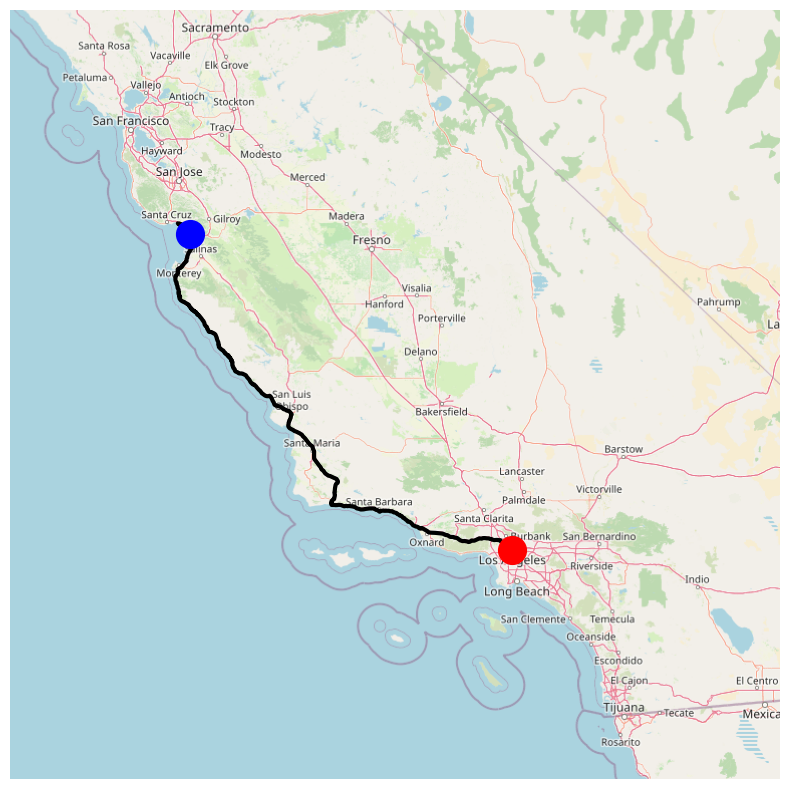

In [56]:
ax = m.show_mpl(figsize=(8, 8))
# Plot the itinerary.
ax.plot(x, y, '-k', lw=3)
# Mark our two positions.
ax.plot(x[0], y[0], 'ob', ms=20)
ax.plot(x[-1], y[-1], 'or', ms=20)

## Compare API nx.dijkstra_path

In [57]:
path = nx.dijkstra_path(sg, tuple(nodes[pos0_i]), tuple(nodes[pos1_i]), weight='distance')
print(path)
print(len(path))
print(nx.dijkstra_path_length(sg, tuple(nodes[pos0_i]), tuple(nodes[pos1_i]), weight='distance'))

[(-121.910796, 36.978296), (-121.77227100000002, 36.883852999999995), (-121.77044000000001, 36.87352599999999), (-121.765708, 36.759420999999996), (-121.912731, 36.567796), (-121.345267, 35.795176999999995), (-121.105997, 35.56953599999999), (-121.069062, 35.54903699999999), (-120.968036, 35.46281), (-120.663604, 35.286750999999995), (-120.663466, 35.286594), (-120.667112, 35.28362599999999), (-120.668087, 35.282367), (-120.66803900000001, 35.28244699999999), (-120.696564, 35.206576999999996), (-120.698242, 35.198546), (-120.432905, 34.98512999999999), (-119.47819900000002, 34.37667199999999), (-119.477927, 34.37656299999999), (-118.81457900000001, 34.152454999999996), (-118.377674, 34.154446), (-118.370582, 34.146982), (-118.252773, 34.06582499999999), (-118.252687, 34.06576299999999)]
24
592.6194488934631


,FULLNAME,MTFCC,RTTYP,distance
0,State Rte 1,S1200,S,17.371936
1,Cabrillo Hwy,S1200,M,1.161328
2,State Rte 1,S1200,S,13.957681
3,State Rte 1,S1200,S,26.979412
4,State Rte 1,S1200,S,119.835869
5,State Rte 1,S1200,S,37.559920
6,Cabrillo Hwy,S1200,M,4.412885
7,State Rte 1,S1200,S,13.486984
8,Cabrillo Hwy,S1200,M,37.244017
9,Cabrillo Hwy,S1200,M,0.021492


"roads['distance'].sum() "

592.6194488934632

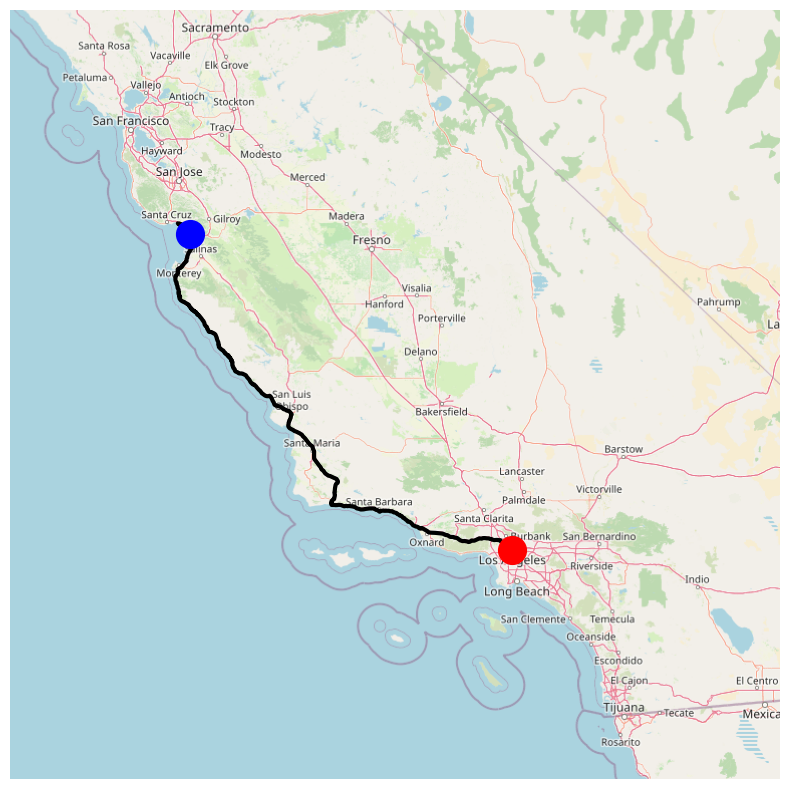

In [58]:
roads = pd.DataFrame(
    [sg.edges[path[i], path[i + 1]]
     for i in range(len(path) - 1)],
    columns=['FULLNAME', 'MTFCC',
             'RTTYP', 'distance'])
display(roads)
display("roads['distance'].sum() ", roads['distance'].sum())
m = smopy.Map(pos0, pos1, z=7, margin=.1)
linepath = get_full_path(path)
x, y = m.to_pixels(linepath[:, 1], linepath[:, 0])
ax = m.show_mpl(figsize=(8, 8))
# Plot the itinerary.
ax.plot(x, y, '-k', lw=3)
# Mark our two positions.
ax.plot(x[0], y[0], 'ob', ms=20)
ax.plot(x[-1], y[-1], 'or', ms=20)

## Compare API nx.astar_path

In [297]:
def dist(a, b):
    (x1, y1) = a
    (x2, y2) = b
    return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5


path = nx.astar_path(sg, tuple(nodes[pos0_i]), tuple(nodes[pos1_i]), heuristic=dist, weight='distance')
print(path)
print(len(path))
print(nx.astar_path_length(sg, tuple(nodes[pos0_i]), tuple(nodes[pos1_i]), heuristic=dist, weight='distance'))

[(-121.910796, 36.978296), (-121.77227100000002, 36.883852999999995), (-121.77044000000001, 36.87352599999999), (-121.765708, 36.759420999999996), (-121.912731, 36.567796), (-121.345267, 35.795176999999995), (-121.105997, 35.56953599999999), (-121.069062, 35.54903699999999), (-120.968036, 35.46281), (-120.663604, 35.286750999999995), (-120.663466, 35.286594), (-120.667112, 35.28362599999999), (-120.668087, 35.282367), (-120.66803900000001, 35.28244699999999), (-120.696564, 35.206576999999996), (-120.698242, 35.198546), (-120.432905, 34.98512999999999), (-119.47819900000002, 34.37667199999999), (-119.477927, 34.37656299999999), (-118.81457900000001, 34.152454999999996), (-118.377674, 34.154446), (-118.370582, 34.146982), (-118.252773, 34.06582499999999), (-118.252687, 34.06576299999999)]
24
592.6194488934631


,FULLNAME,MTFCC,RTTYP,distance
0,State Rte 1,S1200,S,17.371936
1,Cabrillo Hwy,S1200,M,1.161328
2,State Rte 1,S1200,S,13.957681
3,State Rte 1,S1200,S,26.979412
4,State Rte 1,S1200,S,119.835869
5,State Rte 1,S1200,S,37.559920
6,Cabrillo Hwy,S1200,M,4.412885
7,State Rte 1,S1200,S,13.486984
8,Cabrillo Hwy,S1200,M,37.244017
9,Cabrillo Hwy,S1200,M,0.021492


"roads['distance'].sum() "

592.6194488934632

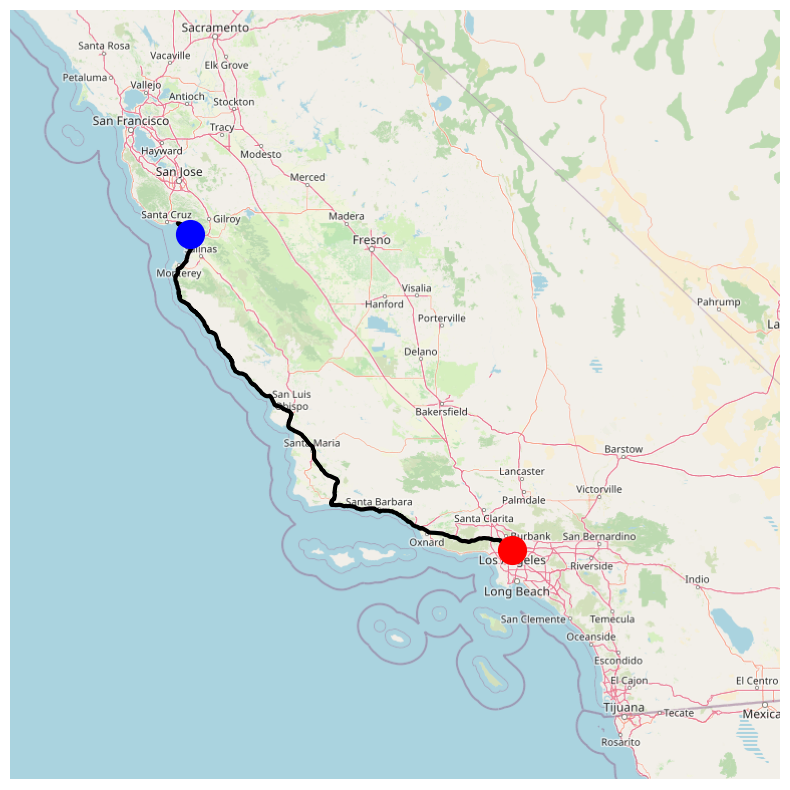

In [296]:
roads = pd.DataFrame(
    [sg.edges[path[i], path[i + 1]]
     for i in range(len(path) - 1)],
    columns=['FULLNAME', 'MTFCC',
             'RTTYP', 'distance'])
display(roads)
display("roads['distance'].sum() ", roads['distance'].sum())
m = smopy.Map(pos0, pos1, z=7, margin=.1)
linepath = get_full_path(path)
x, y = m.to_pixels(linepath[:, 1], linepath[:, 0])
ax = m.show_mpl(figsize=(8, 8))
# Plot the itinerary.
ax.plot(x, y, '-k', lw=3)
# Mark our two positions.
ax.plot(x[0], y[0], 'ob', ms=20)
ax.plot(x[-1], y[-1], 'or', ms=20)